In [12]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.approximation import average_clustering
import community.community_louvain as cl
import pickle
import random
import scipy
from itertools import islice

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22

# Funciones de utiles.py
from utiles import read_graph , read_graph_weighted,get_graph_pos , drop_weights

In [13]:
EMAIL_PATH = 'datasets/email.txt'
TERRORIST_PATH = 'datasets/terrorist.txt'
EMAIL_LABELS_PATH = 'datasets/email_labels.txt'

# Leemos los grafos
email = read_graph(EMAIL_PATH)
terr= read_graph_weighted(TERRORIST_PATH)

# Leemos las etiquetas del dataset de email
array = np.loadtxt(EMAIL_LABELS_PATH, dtype=int)
email_labels=list(array[:,1]) 


terrorist_unweighted = terr.copy()
drop_weights(terrorist_unweighted)
terrorist_unweighted.remove_edges_from(nx.selfloop_edges(terrorist_unweighted)) #remuevo autoenlaces NO HAY
print(terrorist_unweighted)

email.remove_edges_from(nx.selfloop_edges(email))  # Borrar autoenlaces
emailcc = sorted(nx.connected_components(email), key=len, reverse=True)
email_giant = email.subgraph(emailcc[0])



Graph with 64 nodes and 243 edges


In [14]:
modulos = nx.community.girvan_newman(terrorist_unweighted)
modularidad=[] # ESTE EL EL INDICE DE MODULARIDAD (Q) QUE QUEREMOS OPTIMIZAR
mod_max = -999
for communities in modulos:
    n_modularidad = nx.community.modularity(terrorist_unweighted,tuple(sorted(c) for c in communities)) # CALCULAMOS Q PARA CADA ITERACION
    modularidad.append(n_modularidad)
    if n_modularidad>mod_max: # ME GUARDO LA MAXIMA MODULARIDAD ENCONTRADA, Y LA PARTICIÓN DE COMUNIDADES CORRESPONDIENTE
      mod_max=n_modularidad
      com_max = tuple(sorted(c) for c in communities)


k=np.argmax(modularidad)
print('La modularidad de la partición óptima es:',mod_max)
print('La partición óptima tiene ',len(com_max), ' comunidades')
print('La partición óptima es:',com_max)

La modularidad de la partición óptima es: 0.3955189757658893
La partición óptima tiene  15  comunidades
La partición óptima es: ([np.int64(0), np.int64(1), np.int64(2), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(36)], [np.int64(3), np.int64(4), np.int64(16), np.int64(17), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(57), np.int64(58)], [np.int64(18), np.int64(35), np.int64(38), np.int64(54), np.int64(55), np.int64(56)], [np.int64(30), np.int64(39), np.int64(40), np.int64(43)], [np.int64(31)], [np.int64(32)], [np.int64(33)], [np.int64(34)], [np.int64(37)], [np.int64(41)], [np.int64(42)], [np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(60), np.int64(61)], [np.int64(53)], [

In [15]:
def partition_set_to_dict(m):
    d = {}
    for i, c in enumerate(m):
        for n in c:
            d[n] = i
    return d

(np.float64(-0.5571739381423282),
 np.float64(0.6333775308419692),
 np.float64(-0.9132113814959884),
 np.float64(1.181798366567492))

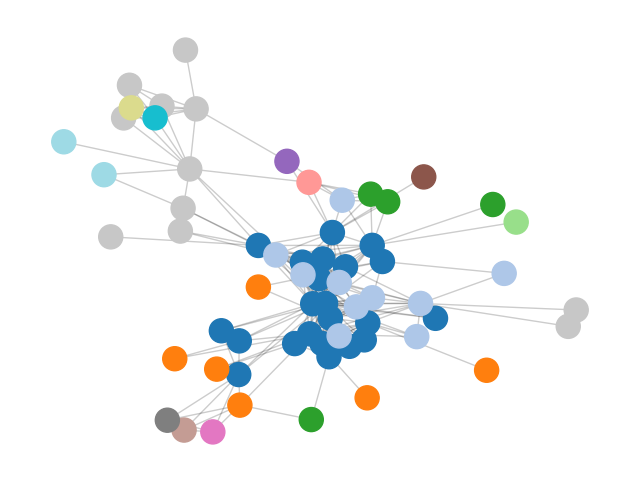

In [16]:
values = [v for n,v in partition_set_to_dict(com_max).items()] # uso como label (color) la comunidad a la que pertenece cada nodo
layout=nx.spring_layout(terrorist_unweighted,iterations=1000) # elegimos como layout el grafo percibido
plt.figure()
nx.draw_networkx_nodes(terrorist_unweighted, layout, node_size=300, node_color = values,cmap=plt.cm.tab20)
nx.draw_networkx_labels(terrorist_unweighted, layout, labels={}, font_weight='bold', font_color='white', font_size=8)
nx.draw_networkx_edges(terrorist_unweighted, layout, alpha=0.2)
plt.axis('off')


La modularidad de la partición óptima es: 0.4483141120086707


(np.float64(-0.5571739381423282),
 np.float64(0.6333775308419692),
 np.float64(-0.9132113814959884),
 np.float64(1.181798366567492))

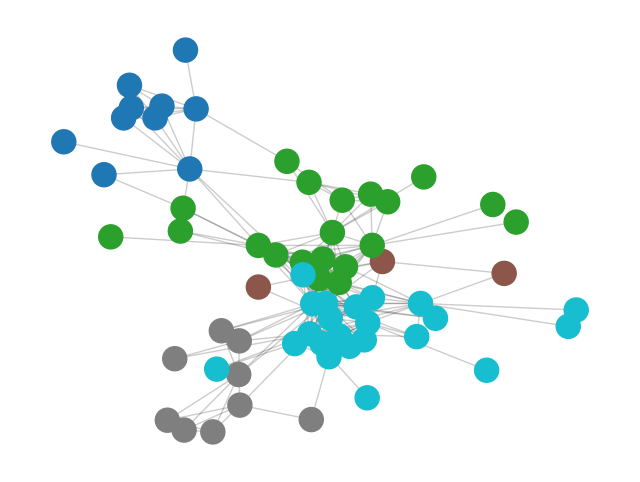

In [17]:
modulos = cl.best_partition(terrorist_unweighted)
print('La modularidad de la partición óptima es:',cl.modularity(modulos,terrorist_unweighted))
values_per = [v for n,v in modulos.items()]

nx.draw_networkx_nodes(terrorist_unweighted, layout, node_size=300, node_color = values_per,cmap=plt.cm.tab10)
nx.draw_networkx_labels(terrorist_unweighted, layout, labels={}, font_weight='bold', font_color='white', font_size=8)
nx.draw_networkx_edges(terrorist_unweighted, layout, alpha=0.2)
plt.axis('off')

El algoritmo de Girvan-Newman identificó 15 comunidades con una modularidad menor (0.396), lo que indica una división más granular pero menos eficaz en términos de cohesión interna. La red aparece más fragmentada, con comunidades pequeñas y conexiones entre ellas más difusas. Esta partición puede capturar subestructuras locales, pero presenta menor claridad en la separación global de la red

Por otro lado, el algoritmo de Louvain detectó 4 comunidades en la red terrorist, con una modularidad de 0.448. Esta partición sugiere una estructura bien modular, donde los nodos están densamente conectados dentro de sus comunidades y presentan pocos enlaces entre grupos. La visualización refleja bloques claramente diferenciados, lo que indica cohesión interna en cada comunidad y una segmentación funcional de la red.


In [ ]:
modularidad = []
particiones = []

modulos = islice(nx.community.girvan_newman(email_giant), 20)
for communities in modulos:
    partition = [sorted(c) for c in communities]
    score = nx.community.modularity(email_giant, partition)

    modularidad.append(score)
    particiones.append(partition)

    if len(modularidad) > 1 and score < modularidad[-2]:
        break  # detenerse si baja la modularidad

# Elegir la mejor partición
k = np.argmax(modularidad)
com_max = particiones[k]
mod_max = modularidad[k]

print('La modularidad de la partición óptima es:', mod_max)
print('La partición óptima tiene', len(com_max), 'comunidades')


In [ ]:
print('Número de nodos por comunidad en la partición óptima:')
for i, comunidad in enumerate(com_max):
    print(f'Comunidad {i+1}: {len(comunidad)} nodos')

Número de nodos por comunidad en la partición óptima:
Comunidad 1: 980 nodos
Comunidad 2: 6 nodos


c:\Users\Pedro\OneDrive\Documentos\Maestria\TP1\.env_cyttp1\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


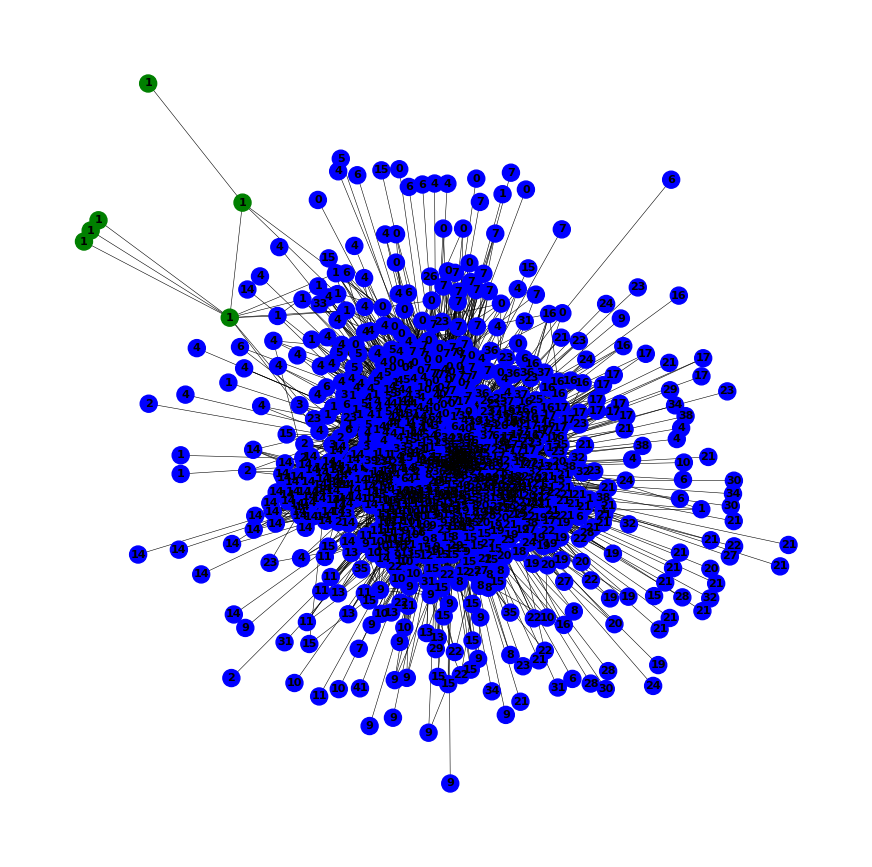

In [ ]:

# Map only two colors: community 0 → blue, community 1 → green
color_map = {0: 'blue', 1: 'green'}

# Get community ID for each node and assign its corresponding color
partition_dict = partition_set_to_dict(com_max)
values = [color_map.get(partition_dict[n], 'gray') for n in email_giant.nodes()]

layout=nx.spring_layout(email_giant,iterations=1000, k=0.6) # elegimos como layout el grafo percibido
labels_for_graph = {node: str(email_labels[node]) for node in email_giant.nodes()}
plt.figure(figsize=(11, 11))
nx.draw_networkx_nodes(email_giant, layout, node_size=150, node_color=values, cmap=plt.cm.tab10)
nx.draw_networkx_labels(email_giant, layout, labels=labels_for_graph,
                        font_weight='bold', font_color='black', font_size=8)
nx.draw_networkx_edges(email_giant, layout, width=0.4)
plt.axis('off')
plt.show()

La modularidad de la partición óptima es: 0.41034037754919067
Cantidad de comunidades detectadas: 8


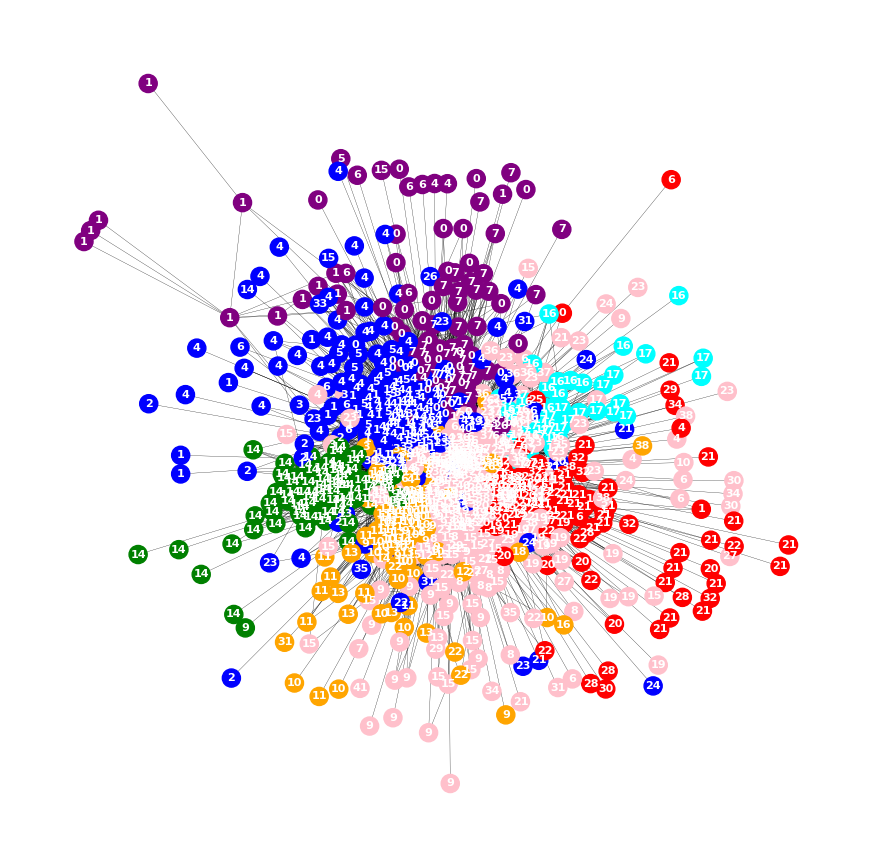

In [ ]:

# Louvain partition
modulos = cl.best_partition(email_giant)
print('La modularidad de la partición óptima es:', cl.modularity(modulos, email_giant))

# Define 7 manual colors
colors = ['blue', 'purple', 'green', 'pink', 'orange', 'red', 'cyan']

# Get unique communities and map each to a color
unique_communities = sorted(set(modulos.values()))
print('Cantidad de comunidades detectadas:', len(unique_communities))

color_map = {community: colors[i % len(colors)] for i, community in enumerate(unique_communities)}

# Assign color to each node
node_colors = [color_map[modulos[node]] for node in email_giant.nodes()]

# Plot
plt.figure(figsize=(11, 11))
nx.draw_networkx_nodes(email_giant, layout, node_size=170, node_color=node_colors)
nx.draw_networkx_labels(email_giant, layout, labels=labels_for_graph, font_weight='bold', font_color='white', font_size=8)
nx.draw_networkx_edges(email_giant, layout, width=0.2)
plt.axis('off')
plt.show()

El algoritmo de Girvan–Newman identificó 2 comunidades en la red de correos electrónicos, con una modularidad extremadamente baja (0.0006).
Esto se debe a que el grafo de emails tiene una densidad baja (3.31% de las conexiones posibles entre nodos), para este caso, el algoritmo no ha logrado dividir la red de forma efectiva, lo que impide realizar un análisis.

En contraste, el algoritmo de Louvain detectó 7 comunidades con una modularidad superior (0.410). Este valor refleja una partición más coherente desde el punto de vista estructural, donde los nodos tienden a concentrar sus conexiones dentro de sus respectivas comunidades.  La visualización muestra conglomerados bien diferenciados, lo que indica una segmentación más funcional de la red. La visualización muestra una estructura bien dividida en grupos, donde los nodos de cada comunidad están fuertemente conectados entre sí y tienen pocas conexiones con otros grupos. 


Ambas redes, la de terroristas y la de correos electrónicos, presentan modularidades cercanas a 0.4. Esto sugiere que, en ambos casos, los nodos tienden a agruparse en comunidades bien definidas, con muchas conexiones internas y pocas hacia otros grupos. En términos estructurales, ambas redes comparten un patrón de organización similar.